# import packages

In [1]:
#Import Pacakges
import pandas as pd
from sbmtm import sbmtm
import graph_tool.all as gt
import pickle
import numpy as np
import pylab as plt
import seaborn as sns
from datetime import datetime
from dateutil import parser
from collections import defaultdict

In [2]:
def mcc_classification(mcc):
    if mcc < 1500:
        return 'Agricultural Services'
    elif mcc < 3000:
        return 'Contracted Services'
    elif mcc < 4800:
        return 'Travel'
    elif mcc < 5000:
        return 'Utility Services'
    elif mcc < 5600:
        return 'Retail Outlet Services'
    elif mcc < 5700:
        return 'Clothing Stores'
    elif mcc < 7300:
        return 'Miscellaneous Stores'
    elif mcc < 8000:
        return 'Business Services'
    elif mcc < 9000:
        return 'Professional Services and Membership Organizations'
    else:
        return 'Government Services'

In [3]:
#filtered_data = pd.read_csv('/Users/ognyansimeonov/Desktop/MAC-MIGS/PhD/Code/Data/Transactions_Data_with_COICOP.csv')
filtered_data = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='Clean_Transfers')
mcc_dict = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='MCC_List', skiprows=10, usecols='A:B', names=['mcc_code', 'Description'])

### data cleaning

# deal with mcc that are classified into multiple categories (keep the main category)
tempdf = filtered_data.groupby('MCC_List')['externalParty.transactionCategory'].value_counts(ascending=False).reset_index()
tempdf = tempdf.drop_duplicates(subset=['MCC_List'], keep='first')
# remap the categories to the filtered_data
filtered_data['externalParty.transactionCategory'] = filtered_data['MCC_List'].map(tempdf.set_index('MCC_List')['externalParty.transactionCategory'])

# select transactions with amount > 10
filtered_data = filtered_data[filtered_data['amount.value'] > 10]
# select customers with more than 10 transactions
filtered_data = filtered_data[filtered_data['customerId'].map(filtered_data['customerId'].value_counts()) > 10]
# map the mcc_dict to the filtered_data and drop the rows with NaN MCC values
filtered_data['MCC_List'] = filtered_data['externalParty.merchantCategoryCode'].map(mcc_dict.set_index('mcc_code')['Description'])
filtered_data = filtered_data.dropna(subset=['MCC_List'])
# fill the missing carbon emission values with the calculated carbon emission values based on the emission rate of the MCC
# calculate the emission rate of each transaction
filtered_data['emission_rate'] = filtered_data.apply(lambda x: x['transactionFootPrint.carbonEmissionInGrams']/x['amount.value'] if x['amount.value']!=0 else 0, axis=1)
# find the emission rate of each MCC
df_emission_rate = filtered_data.groupby('MCC_List')['emission_rate'].max().sort_values(ascending=True).reset_index().set_index('MCC_List').fillna(0)
# calculate the carbon emission of each transaction where missing
filtered_data['transactionFootPrint.carbonEmissionInGrams'] = filtered_data.apply(lambda x: x['amount.value']*df_emission_rate.loc[x['MCC_List']], axis=1)
filtered_data['mcc_classification'] = filtered_data['externalParty.merchantCategoryCode'].apply(mcc_classification)

df = filtered_data 

# Create a dictionary to store MCC lists for each customer
customer_mcc_dict = {}

# Iterate through the dataframe
for _, row in df.iterrows():
    customer_id = row['customerId']
    mcc = row['MCC_List']

    # Check if the customer_id is already in the dictionary
    if customer_id in customer_mcc_dict:
        customer_mcc_dict[customer_id].append(mcc)
    else:
        customer_mcc_dict[customer_id] = [mcc]

# build a network

In [4]:
# calculate the proportion of each MCC for each customer
proportion_matrix = filtered_data.groupby('customerId')['MCC_List'].value_counts(normalize=True).unstack().fillna(0)
proportion_matrix

MCC_List                              Advertising Services  Aer Lingus  \
customerId                                                               
01968de9-41cb-4509-b0a6-6bdc02700150                   0.0         0.0   
01b34ce5-ce43-4c2d-a73d-5294376bd399                   0.0         0.0   
01b4698f-32be-4bc0-9b69-b3024ac18004                   0.0         0.0   
01ef943c-d661-48b0-9c0b-bb456a7d998d                   0.0         0.0   
03025a2b-9179-4da9-8dff-af4a3179ce7f                   0.0         0.0   
...                                                    ...         ...   
fcfd36e4-da5e-42d1-8769-8213878b08fe                   0.0         0.0   
fd654d64-f795-401d-a5fe-76cfa2cfa01a                   0.0         0.0   
feb37e88-b280-40b8-b887-30961016417c                   0.0         0.0   
ff6ef7e8-4b43-44f7-a1ef-7d35407c2219                   0.0         0.0   
ffcf3506-a7d8-48a0-ba54-d4d54d15ee78                   0.0         0.0   

MCC_List                              Airlines and Air Carriers  \
customerId                                                        
01968de9-41cb-4509-b0a6-6bdc02700150                   0.000000   
01b34ce5-ce43-4c2d-a73d-5294376bd399                   0.000000   
01b4698f-32be-4bc0-9b69-b3024ac18004                   0.000000   
01ef943c-d661-48b0-9c0b-bb456a7d998d                   0.000000   
03025a2b-9179-4da9-8dff-af4a3179ce7f                   0.000000   
...                                                         ...   
fcfd36e4-da5e-42d1-8769-8213878b08fe                   0.000000   
fd654d64-f795-401d-a5fe-76cfa2cfa01a                   0.009119   
feb37e88-b280-40b8-b887-30961016417c                   0.000000   
ff6ef7e8-4b43-44f7-a1ef-7d35407c2219                   0.000000   
ffcf3506-a7d8-48a0-ba54-d4d54d15ee78                   0.000000   

MCC_List                              Airports, Flying Fields, and Airport Terminals   \
customerId                                                                              
01968de9-41cb-4509-b0a6-6bdc02700150                                              0.0   
01b34ce5-ce43-4c2d-a73d-5294376bd399                                              0.0   
01b4698f-32be-4bc0-9b69-b3024ac18004                                              0.0   
01ef943c-d661-48b0-9c0b-bb456a7d998d                                              0.0   
03025a2b-9179-4da9-8dff-af4a3179ce7f                                              0.0   
...                                                                               ...   
fcfd36e4-da5e-42d1-8769-8213878b08fe                                              0.0   
fd654d64-f795-401d-a5fe-76cfa2cfa01a                                              0.0   
feb37e88-b280-40b8-b887-30961016417c                                              0.0   
ff6ef7e8-4b43-44f7-a1ef-7d35407c2219                                              0.0   
ffcf3506-a7d8-48a0-ba54-d4d54d15ee78                                              0.0   

MCC_List                              Amusement Parks, Circuses, Carnivals, and Fortune Tellers   \
customerId                                                                                         
01968de9-41cb-4509-b0a6-6bdc02700150                                           0.000000            
01b34ce5-ce43-4c2d-a73d-5294376bd399                                           0.000000            
01b4698f-32be-4bc0-9b69-b3024ac18004                                           0.000000            
01ef943c-d661-48b0-9c0b-bb456a7d998d                                           0.000000            
03025a2b-9179-4da9-8dff-af4a3179ce7f                                           0.000000            
...                                                                                 ...            
fcfd36e4-da5e-42d1-8769-8213878b08fe                                           0.000000            
fd654d64-f795-401d-a5fe-76cfa2cfa01a                                           0.000000            
feb37e8

In [5]:
# calculate the average proportion
average_proportion = proportion_matrix.mean()
average_proportion

MCC_List
Advertising Services                                          0.004126
Aer Lingus                                                    0.000052
Airlines and Air Carriers                                     0.000147
Airports, Flying Fields, and Airport Terminals                0.000007
Amusement Parks, Circuses, Carnivals, and Fortune Tellers     0.000324
                                                                ...   
Watch, Clock, and Jewelry Repair Shops                        0.000013
Wholesale Club with or without membership fee                 0.000169
Wig & Toupee Shops                                            0.000250
Women's Accessory and Specialty Stores                        0.000007
Women's Ready-to-Wear Stores                                  0.000538
Length: 199, dtype: float64

In [6]:
# create a connection matrix between customers and MCCs if proportion of customer's transactions is greater than the average proportion
connection_matrix = proportion_matrix > average_proportion
connection_matrix = connection_matrix.astype(int)
connection_matrix

MCC_List                              Advertising Services  Aer Lingus  \
customerId                                                               
01968de9-41cb-4509-b0a6-6bdc02700150                     0           0   
01b34ce5-ce43-4c2d-a73d-5294376bd399                     0           0   
01b4698f-32be-4bc0-9b69-b3024ac18004                     0           0   
01ef943c-d661-48b0-9c0b-bb456a7d998d                     0           0   
03025a2b-9179-4da9-8dff-af4a3179ce7f                     0           0   
...                                                    ...         ...   
fcfd36e4-da5e-42d1-8769-8213878b08fe                     0           0   
fd654d64-f795-401d-a5fe-76cfa2cfa01a                     0           0   
feb37e88-b280-40b8-b887-30961016417c                     0           0   
ff6ef7e8-4b43-44f7-a1ef-7d35407c2219                     0           0   
ffcf3506-a7d8-48a0-ba54-d4d54d15ee78                     0           0   

MCC_List                              Airlines and Air Carriers  \
customerId                                                        
01968de9-41cb-4509-b0a6-6bdc02700150                          0   
01b34ce5-ce43-4c2d-a73d-5294376bd399                          0   
01b4698f-32be-4bc0-9b69-b3024ac18004                          0   
01ef943c-d661-48b0-9c0b-bb456a7d998d                          0   
03025a2b-9179-4da9-8dff-af4a3179ce7f                          0   
...                                                         ...   
fcfd36e4-da5e-42d1-8769-8213878b08fe                          0   
fd654d64-f795-401d-a5fe-76cfa2cfa01a                          1   
feb37e88-b280-40b8-b887-30961016417c                          0   
ff6ef7e8-4b43-44f7-a1ef-7d35407c2219                          0   
ffcf3506-a7d8-48a0-ba54-d4d54d15ee78                          0   

MCC_List                              Airports, Flying Fields, and Airport Terminals   \
customerId                                                                              
01968de9-41cb-4509-b0a6-6bdc02700150                                                0   
01b34ce5-ce43-4c2d-a73d-5294376bd399                                                0   
01b4698f-32be-4bc0-9b69-b3024ac18004                                                0   
01ef943c-d661-48b0-9c0b-bb456a7d998d                                                0   
03025a2b-9179-4da9-8dff-af4a3179ce7f                                                0   
...                                                                               ...   
fcfd36e4-da5e-42d1-8769-8213878b08fe                                                0   
fd654d64-f795-401d-a5fe-76cfa2cfa01a                                                0   
feb37e88-b280-40b8-b887-30961016417c                                                0   
ff6ef7e8-4b43-44f7-a1ef-7d35407c2219                                                0   
ffcf3506-a7d8-48a0-ba54-d4d54d15ee78                                                0   

MCC_List                              Amusement Parks, Circuses, Carnivals, and Fortune Tellers   \
customerId                                                                                         
01968de9-41cb-4509-b0a6-6bdc02700150                                                  0            
01b34ce5-ce43-4c2d-a73d-5294376bd399                                                  0            
01b4698f-32be-4bc0-9b69-b3024ac18004                                                  0            
01ef943c-d661-48b0-9c0b-bb456a7d998d                                                  0            
03025a2b-9179-4da9-8dff-af4a3179ce7f                                                  0            
...                                                                                 ...            
fcfd36e4-da5e-42d1-8769-8213878b08fe                                                  0            
fd654d64-f795-401d-a5fe-76cfa2cfa01a                                                  0            
feb37e8

In [7]:
# stack the connection matrix to create a list of tuples
connection_list = connection_matrix.stack().reset_index()
connection_list.columns = ['customerId', 'MCC_List', 'connection']
connection_list = connection_list[connection_list['connection'] == 1]
connection_list

customerId  \
15     01968de9-41cb-4509-b0a6-6bdc02700150   
17     01968de9-41cb-4509-b0a6-6bdc02700150   
25     01968de9-41cb-4509-b0a6-6bdc02700150   
30     01968de9-41cb-4509-b0a6-6bdc02700150   
49     01968de9-41cb-4509-b0a6-6bdc02700150   
...                                     ...   
73401  ffcf3506-a7d8-48a0-ba54-d4d54d15ee78   
73403  ffcf3506-a7d8-48a0-ba54-d4d54d15ee78   
73406  ffcf3506-a7d8-48a0-ba54-d4d54d15ee78   
73414  ffcf3506-a7d8-48a0-ba54-d4d54d15ee78   
73424  ffcf3506-a7d8-48a0-ba54-d4d54d15ee78   

                                          MCC_List  connection  
15                                        Bakeries           1  
17                         Beauty and Barber Shops           1  
25         Bus Lines, includes Charters/Tour Buses           1  
30            Candy, Nut, and Confectionary Stores           1  
49                        Computer Software Stores           1  
...                                            ...         ...  
73401                                  Shoe Stores           1  
73403             Sporting and Recreational Camps            1  
73406  Stationery, Office and School Supply Stores           1  
73414             Tourist Attractions and Exhibits           1  
73424                  Video Amusement Game Supply           1  

[3377 rows x 3 columns]

In [8]:
customer_mcc_dict = {}
for _, row in connection_list.iterrows():
    customer_id = row['customerId']
    mcc = row['MCC_List']

    # Check if the customer_id is already in the dictionary
    if customer_id in customer_mcc_dict:
        customer_mcc_dict[customer_id].append(mcc)
    else:
        customer_mcc_dict[customer_id] = [mcc]
customer_mcc_dict

{'01968de9-41cb-4509-b0a6-6bdc02700150': ['Bakeries',
  'Beauty and Barber Shops',
  'Bus Lines, includes Charters/Tour Buses',
  'Candy, Nut, and Confectionary Stores',
  'Computer Software Stores',
  'Continuity/Subscription Merchants',
  'Direct Marketing/Direct Marketers--Not Elsewhere Classified',
  'Discount Store',
  'Drinking Places (Alcoholic Beverages) - Bars, Taverns, Nightclubs, Cocktail Lounges, and Discotheques',
  'Duty Free Stores',
  'Eating Places and Restaurants',
  'Electrical Parts and Equipment (Business to Business MCC)\xa0',
  'Florists',
  'Government Services - Not Elsewhere Classified\xa0',
  'Grocery Stores and Supermarkets',
  'Lodging - Hotels, Motels, and Resorts',
  'Miscellaneous & Specialty Retail Stores',
  'Miscellaneous Apparel and Accessory Stores',
  'Miscellaneous Personal Services - Not Elsewhere Classified',
  'Package Stores--Beer, Wine, and Liquor',
  'Postal Services',
  'Ryan Air - RYANAIR',
  'Stationery, Office and School Supply Stores',


In [9]:
# Create the CustomerID array
CustomerID = list(customer_mcc_dict.keys())

# Create the MCC array by zipping the two lists together
MCC = [customer_mcc_dict[customer_id] for customer_id in CustomerID]

# Check if all values in CustomerID are unique
are_all_unique = len(CustomerID) == len(set(CustomerID))
print(len(CustomerID))

369


In [10]:
# Check if all values in CustomerID are unique
are_all_unique = len(CustomerID) == len(set(CustomerID))

if are_all_unique:
    print("All values in CustomerID are unique.")
else:
    print("There are duplicate values in CustomerID.")

All values in CustomerID are unique.


In [11]:
#Check for a random customer/MCC in Excel to make sure it is correct
i_doc = 363
print(CustomerID[i_doc])
print(MCC[i_doc][:10])

fccc649d-a523-4f39-bc66-1e46a8ced7e5
['Eating Places and Restaurants', 'Hardware Stores, Equipment Utilities Regulated', 'Local and Suburban Commuter Passenger Transportation, including Ferries', 'Membership Clubs (Sports, Recreation, Athletic), Country Clubs, and Private Golf Courses', 'Motion Picture Theater', 'News Dealers & Newsstands', 'Parking Lots and Garages', 'Quick Payment Service-Fast Food Restaurants', 'Service Stations (with or without Ancillary Services)', 'Taxicabs and Limousines']


# Create Model and Plot

In [12]:
## Create the sbmtm model
model = sbmtm()

## we have to create the customer-MCC network from the data
model.make_graph(MCC,documents=CustomerID,counts=False, count_log=False)

model.g

<Graph object, undirected, with 568 vertices and 3377 edges, 2 internal vertex properties, at 0x7fef7e824d10>

In [13]:
SEED = 41
gt.seed_rng(SEED) ## seed for graph-tool's random number generator --> same results

#fit the model
model.fit(n_init=100, verbose=False)

print('The lowest entropy was {}, and the state has {} blocks at level 0'.format(model.state.entropy(),model.state.get_levels()[0].get_nonempty_B()))
with open('./Results/uw_minimized_model_seed_{}.pkl'.format(SEED),'wb') as f:
    pickle.dump(model,f)

11061.814492516633
11042.147502167765
11040.387864822005
11049.939305138412
11049.716129103555
11052.90431677239
11043.22638368167
11127.204009063138
11054.992485255329
11042.766111709918
11048.749710768987
11054.748450092466
11055.061664527624
11127.204009063138
11044.384441966293
11047.380663893327
11127.204009063138
11048.211131973723
11048.118879046779
11052.124251659185
11048.803769743346
11046.108211700312
11045.73465499514
11050.533303673888
11047.55011729267
11053.056544574265
11049.329526539066
11053.100526438337
11046.872105861768
11043.689500662906
11048.523665828174
11050.364154876212
11046.256481347973
11049.783072399418
11127.204009063138
11060.74198169495
11044.886374226144
11043.322949010568
11050.041853884344
11048.417415860804
11047.854694156898
11050.501963608625
11055.043513522549
11043.084658972872
11127.204009063138
11053.674303704298
11044.710401443703
11052.52939271402
11054.976579731507
11043.380807124631
11060.325088315387
11127.204009063138
11050.111017459078

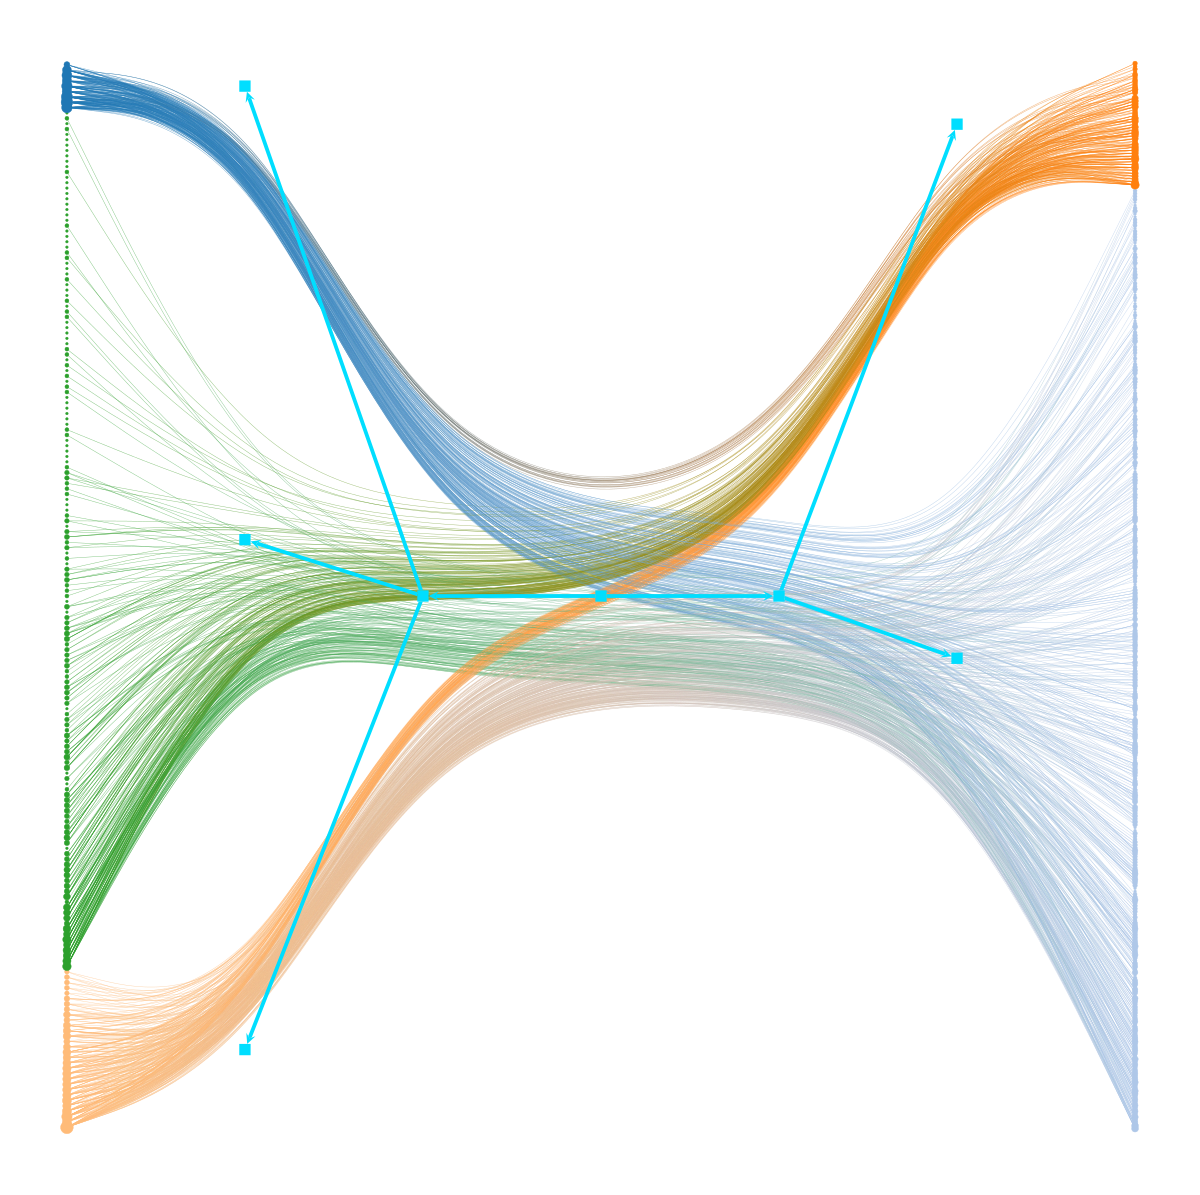

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fef7e824d10, at 0x7fef804cf2c0>,
 <GraphView object, directed, with 576 vertices and 575 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fef80ceee70, at 0x7fef7e62fce0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fef80ceee70, at 0x7fef7e62da30>, False), at 0x7fef80ceee70>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fef80ceee70, at 0x7fef7e62c5c0>)

In [14]:
#Plot
model.state.draw(subsample_edges=1000,layout='bipartite',bip_aspect=1,
           hvertex_size=8, hedge_pen_width=1.9, hedge_color="#00deff", hvertex_fill_color="#00DEFF", output_size=(600, 600))

In [15]:
with open("./Results/uw_minimized_model_seed_{}.pkl".format(SEED), "rb") as f:
        model_100 = pickle.load(f)
print('This state has {} blocks at level 0, {} at level 1, and its entropy is entropy: {:.2f}'.format(model_100.state.get_levels()[0].get_nonempty_B(),model_100.state.get_levels()[1].get_nonempty_B(),model_100.state.entropy()))

This state has 5 blocks at level 0, 2 at level 1, and its entropy is entropy: 11040.07


In [16]:
starting_entropy=model_100.state.entropy()
entropy_gain_multiflip=[model_100.state.multiflip_mcmc_sweep(beta=np.inf, niter=10)[0] for i in range(1000)]

In [17]:
model_100.state.entropy()

11040.001108985001

In [18]:
entropy_diff = np.cumsum(np.array(entropy_gain_multiflip))
entropy_diff_positive = -entropy_diff
# entropy_exp_10 = entropy_diff_positive/(np.log(2)+np.log(5))
# entropy_likelihood = np.power(10,entropy_exp_10)

In [19]:
with open('./Results/uw_multiflip_mcmc_model_seed_{}.pkl'.format(SEED),'wb') as f:
    pickle.dump(model_100,f)

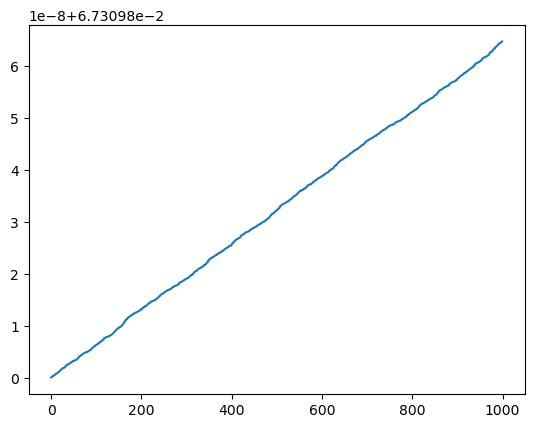

In [20]:
plt.plot(entropy_diff_positive)

In [21]:
print('This state has {} blocks at level 0, {} at level 1, and its entropy is entropy: {:.2f}'.format(model_100.state.get_levels()[0].get_nonempty_B(),model_100.state.get_levels()[1].get_nonempty_B(),model_100.state.entropy()))

This state has 5 blocks at level 0, 2 at level 1, and its entropy is entropy: 11040.00


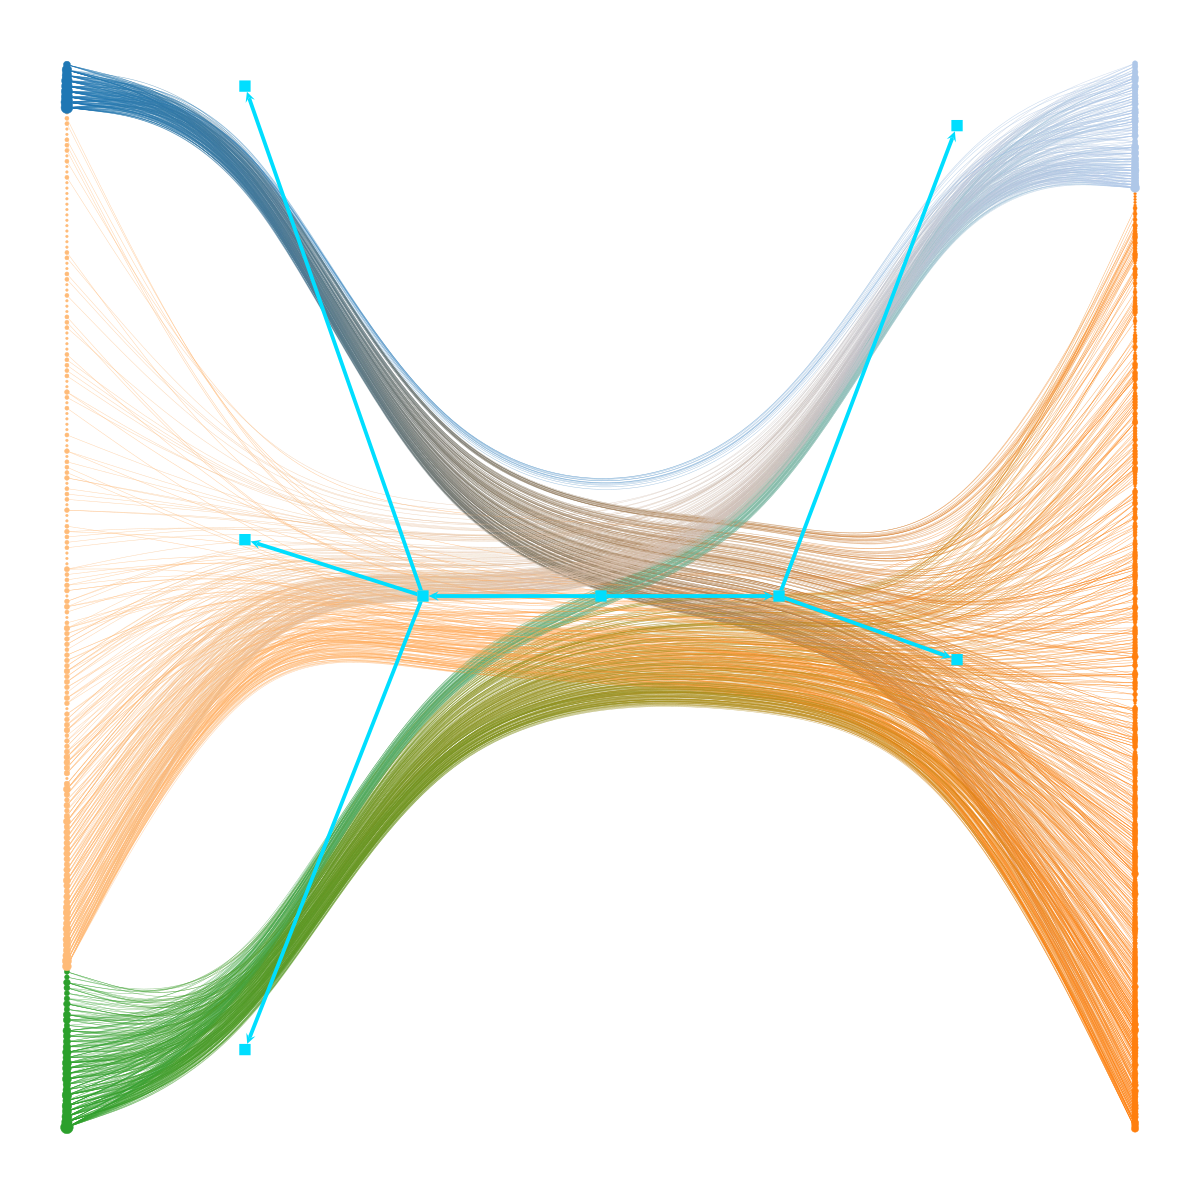

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fef7e827860, at 0x7fef7e590440>,
 <GraphView object, directed, with 576 vertices and 575 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fef7e62d130, at 0x7fef7e2b80e0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fef7e62d130, at 0x7fef7e62c470>, False), at 0x7fef7e62d130>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fef7e62d130, at 0x7fef80772540>)

In [22]:
#Plot
model_100.state.draw(subsample_edges=1000,layout='bipartite',bip_aspect=1,
           hvertex_size=8, hedge_pen_width=1.9, hedge_color="#00deff", hvertex_fill_color="#00DEFF", output_size=(600, 600))

In [23]:
# get the number of documents in each topic(cluster) at level 1
# model.clusters(l=1)
# print the number of documents in each topic(cluster) at level 1
x = 0
for i in range(len(model_100.clusters(l=0))):
    x += len(model_100.clusters(l=0,n=400)[i])
    print('The number of documents in topic {} is {}'.format(i+1,len(model_100.clusters(l=0,n=400)[i])))
print('The total number of documents is {}'.format(x))

The number of documents in topic 1 is 44
The number of documents in topic 2 is 325
The total number of documents is 369


<Axes: >

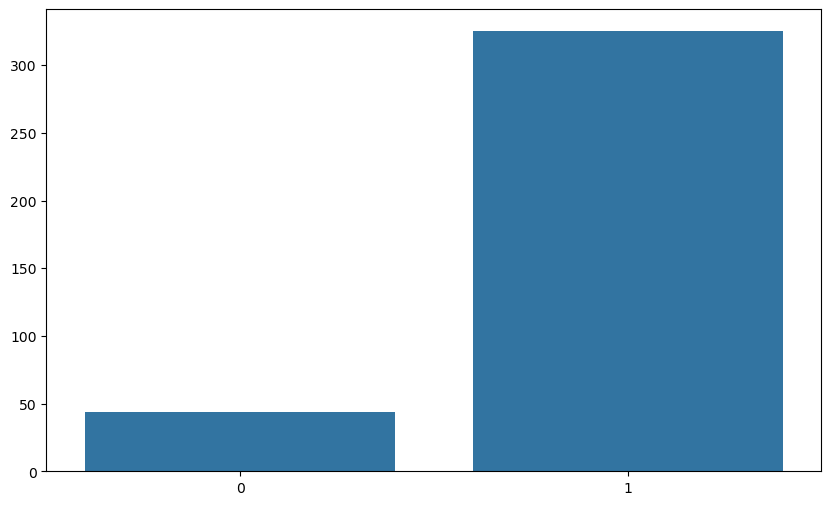

In [24]:
# plot the number of documents in each topic(cluster) at level 1, labeled by the topic(cluster) number
plt.figure(figsize=(10,6))
sns.barplot([len(model_100.clusters(l=0,n=400)[i]) for i in range(len(model_100.clusters(l=0)))])

# Model Analysis

In [25]:
Customer_clusters = model_100.clusters(l=0,n=1000).items()
Customer_clusters = [[id for id, p in cluster] for i, cluster in Customer_clusters]
Customer_clusters

[['d7742e27-7677-431e-8da4-426e977e958e',
  'e1090e22-632f-45e4-a480-b9206b3a573d',
  'bae5dffb-f840-4b05-843a-b1a1e50bf98e',
  'ba5bf2df-a4ff-44d4-b3c9-1dab98b87580',
  '40145ab5-241c-47c5-bb6a-3a05374b28a9',
  'fd654d64-f795-401d-a5fe-76cfa2cfa01a',
  'a4c47159-e445-4b31-8ea9-6c5852bd7095',
  '248d3016-b0ad-41a3-b287-8477efdc36c4',
  '3d78c995-27f2-44f8-b1ed-814805ee3151',
  '923e9cd3-7c8e-4f9d-8e21-d66438382db9',
  '886926ad-2f76-4746-a7fc-ca1473c848a3',
  '0c922076-e434-411a-8a3e-1c06b00979f4',
  'fcfd36e4-da5e-42d1-8769-8213878b08fe',
  'b1f49bc3-ec64-4182-9ab8-3aeaaaf72785',
  'b3ec512b-ffff-4d83-baa3-ecd8374a398b',
  '34f30c26-4ab6-4b64-94f2-ccdf4cd0b1c1',
  'ce3d4f74-f5ea-4d78-8ba8-ceca45235edb',
  '9b360110-de0a-4c9f-a913-0186e642f1f2',
  'b2b7ac22-8e95-460f-a6e7-a94a3b3b01df',
  '1a20b9da-7ae4-4dd1-a27e-b6883585dec0',
  'b2a6900a-e6e6-4875-bf1b-b41c13c0dfc8',
  'a1517511-9d76-464a-b647-861137a07034',
  'b15a3e38-2f9d-434d-9814-094ca59a18c7',
  'a926714a-3061-4fe5-a890-c96c302

In [26]:
l0 = model_100.clusters(l=0,n=1000).items()
l0 = [(id, i) for i, cluster in l0 for id, p in cluster]
df_clusters = pd.DataFrame(l0, columns=['node', 'level_0'])
df_clusters

node  level_0
0    d7742e27-7677-431e-8da4-426e977e958e        0
1    e1090e22-632f-45e4-a480-b9206b3a573d        0
2    bae5dffb-f840-4b05-843a-b1a1e50bf98e        0
3    ba5bf2df-a4ff-44d4-b3c9-1dab98b87580        0
4    40145ab5-241c-47c5-bb6a-3a05374b28a9        0
..                                    ...      ...
364  f601e896-6666-4ff6-a6d0-4748d1412f24        1
365  f5cb8a1b-f495-4bf5-b261-d3704e2d9324        1
366  f5bd29b1-42a1-474e-a260-abd9f132c339        1
367  f582fbee-0081-4b1c-b009-3e45cd4950f6        1
368  f47e9533-fe63-45ef-a7d8-1c0886dff2d9        1

[369 rows x 2 columns]

In [37]:
l0 = model_100.topics(l=0,n=1000).items()
l0 = [(id, i, p) for i, cluster in l0 for id, p in cluster]
df_topics = pd.DataFrame(l0, columns=['node', 'level_0', 'p'])
df_topics

node  level_0         p
0             Gift, Card, Novelty, and Souvenir Stores        0  0.042045
1          Charitable and Social Service Organizations        0  0.037098
2                Lodging - Hotels, Motels, and Resorts        0  0.030503
3                                             Bakeries        0  0.028854
4                        Caterers - Prepare & Delivery        0  0.028854
..                                                 ...      ...       ...
194  Service Stations (with or without Ancillary Se...        2  0.110303
195  Local and Suburban Commuter Passenger Transpor...        2  0.096970
196                            Taxicabs and Limousines        2  0.084848
197  Telecommunication Services, Including Local an...        2  0.073939
198  Cable, Satellite, and Other Pay Television and...        2  0.025455

[199 rows x 3 columns]

In [39]:
df_topics['node'].nunique()

199

## IMD and Age by clusters

In [92]:
df_imd = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='IMD_Rank')
df_imd.drop_duplicates(subset='CustomerId', inplace=True)
df_customer = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='ekko_customer_info')
print('Before dropping NaN values:')
print(df_imd.shape)
print(df_customer.shape)
df_imd.dropna(inplace=True)
df_imd.reset_index(drop=True, inplace=True)
df_customer.dropna(inplace=True)
df_customer.reset_index(drop=True, inplace=True)
print('After dropping NaN values:')
print(df_imd.shape)
print(df_customer.shape)
df_customer.head()

Before dropping NaN values:
(873, 28)
(12986, 6)
After dropping NaN values:
(873, 28)
(11931, 6)


Sender_customer_Id address.postcode address.townOrCity  \
0  eecbba00-41c0-4111-ae83-286a302fed0c          NW1 9DR             London   
1  dff827bc-d6bb-4fd0-ae3d-d82786f9e5ad          SM2 6DU             Sutton   
2  bb10d50e-5e6a-43c2-bd6d-323b7d9c731f          SW1W0NY             London   
3  5c0a9926-a3b5-4441-945b-c1f619ed339a           SM25HT             Sutton   
4  12ea2e69-cea2-4e47-9d21-55402dd47811          SW1W0NY             London   

                  createdAt               dateOfBirth     nationality  
0  2021-11-04T12:46:07.257Z  1995-05-21T00:00:00.000Z  United Kingdom  
1  2021-12-09T18:04:46.294Z  1981-10-30T00:00:00.000Z  United Kingdom  
2  2021-12-15T11:41:54.937Z  1991-04-11T00:00:00.000Z  United Kingdom  
3  2021-12-15T13:33:27.821Z  1986-05-22T00:00:00.000Z  United Kingdom  
4  2021-12-15T14:31:52.354Z  1991-04-11T00:00:00.000Z  United Kingdom

In [93]:
# calculate the age of the customers
df_customer['age'] = df_customer.apply(lambda x: 2024 - parser.parse(x['dateOfBirth']).year, axis=1)
# df_customer.head()

In [94]:
df_imd['age'] = df_imd['CustomerId'].map(df_customer.set_index('Sender_customer_Id')['age'])
# df_imd['level_0'] = df_imd['CustomerId'].map(df_clusters.set_index('node')['level_0'])
df_imd.head()

CustomerId  Index_of_Multiple_Deprivation_Decile  \
0  db9b8ecb-173d-43fb-bff6-b7f7b54b603b                                     3   
1  60614561-6838-4200-a37c-978cdffad096                                     2   
2  886926ad-2f76-4746-a7fc-ca1473c848a3                                     9   
3  55929e08-6995-4766-ad89-402bb47358f8                                     4   
4  ae54b0a2-7ad3-432c-ae1b-040e9365f8ee                                     7   

  Postcode_Status  LSOA_code                   LSOA_Name  \
0            Live  E01010959   Calderdale 020D E01010959   
1            Live  E01011043     Kirklees 031B E01011043   
2            Live  E01004694  Westminster 016C E01004694   
3            Live  E01027498     Tynedale 005B E01027498   
4            Live  E01001642    Greenwich 038C E01001642   

   Index_of_Multiple_Deprivation_Rank  Income_Rank  Income_Decile  \
0                                8106         7040              3   
1                                5947         6529              2   
2                               26491        31488             10   
3                               12152         8097              3   
4                               22742        26579              9   

   Income_Score  Employment_Rank  ...  \
0         0.194             5093  ...   
1         0.202             6750  ...   
2         0.026            32231  ...   
3         0.179             9178  ...   
4         0.048            30198  ...   

   Barriers_to_Housing_and_Services_Decile  Living_Environment_Rank  \
0                                       10                     9666   
1                                        5                     1975   
2                                        3                     5526   
3                                        8                    32328   
4                                        6                     6012   

   Living_Environment_Decile  IDACI_Rank  IDACI_Decile  IDACI_Score  \
0                          3        6327             2        0.260   
1                          1        9700             3        0.206   
2                          2       32013            10        0.019   
3                         10        9016             3        0.216   
4                          2       21946             7        0.082   

   IDAOPI_Rank  IDAOPI_Decile  IDAOPI_Score   age  
0        12134              4         0.172  29.0  
1         3799              2         0.324  26.0  
2        19729              7         0.102  27.0  
3         7387              3         0.241  28.0  
4        25719              8         0.067  56.0  

[5 rows x 29 columns]

In [59]:
def calculate_average_age_and_IMD(cluster_index, df_imd, clusters):
    # Get the customer IDs in the specified cluster
    customer_cluster = clusters[cluster_index]

    # Filter the DataFrame to include only customers in the current cluster
    cluster_data = df_imd[df_imd['CustomerId'].isin(customer_cluster)]
    
    # Calculate the average age and IMD_Rank for the cluster
    average_age = cluster_data['age'].mean()
    average_IMD = cluster_data['Index_of_Multiple_Deprivation_Decile'].mean()
    
    return average_age, average_IMD
customer_data_cleaned = df_imd
# Example usage:
for index in range(len(Customer_clusters)):
    cluster_index = index  # Replace this with the desired cluster index
    avg_age, avg_IMD = calculate_average_age_and_IMD(cluster_index, customer_data_cleaned, Customer_clusters)
    print(f"For cluster {cluster_index + 1}, the average age is {avg_age:.2f} and the average IMD_Rank is {avg_IMD:.2f}")


For cluster 1, the average age is 40.00 and the average IMD_Rank is 6.54
For cluster 2, the average age is 30.16 and the average IMD_Rank is 4.14


## Heatmaps of Purchases by Cluster

In [60]:
def heatmaps(df_clusters, df, yvalues=['MCC_List'], xvalues=['levels'], topn=False, relative=False, value='frequency', level_detail=False, max_label_len=False):
    '''
    df_clusters: DataFrame, the DataFrame with the cluster information
    df: DataFrame, the DataFrame with the transactions data
    yvalues: list, hierarchical levels to be used as y-axis values (categories)
    xvalues: list, hierarchical levels to be used as x-axis values (levels)
    topn: int, the number of top categories to be shown in the heatmap, valid only if yvalues has one level
    relative: bool, if True, the heatmap will show the relative frequency of the categories
    '''
    if len(yvalues) == 2:
        df['y'] = df[yvalues[0]] + '_' + df[yvalues[1]]
        annot = False
        ytick = False
    else:
        df['y'] = df[yvalues[0]]
        annot = True
        ytick = True
    # population average of the transactions frequency/amount for calculating the relative frequency
    if value == 'frequency':
        df_avg = df['y'].value_counts(normalize=True).reset_index().set_index('y')
        df['count'] = 1
    elif value == 'amount':
        df_avg = (df.groupby('y')['amount.value'].sum()/df['amount.value'].sum()).rename('proportion').reset_index().set_index('y')
        df['count'] = df['amount.value']

    # Get the normalized MCC transaction counts for each cluster
    cluster_counts = []
    for cluster in df_clusters[xvalues[-1]].unique():
        # Filter the DataFrame based on the customer IDs in the cluster
        custid = df_clusters[df_clusters[xvalues[-1]] == cluster]['node'].values
        filtered_df = df[df['customerId'].isin(custid)]
        if relative:
            # Calculate the normalized counts for each MCC category
            # counts = np.log(filtered_df[yvalues[-1]].value_counts(normalize=True) / df_avg['proportion']).rename(cluster)
            counts = np.log((filtered_df.groupby('y')['count'].sum()/filtered_df['count'].sum()) / df_avg['proportion']).rename(cluster)
        else:
            counts = (filtered_df.groupby('y')['count'].sum()/filtered_df['count'].sum()).rename(cluster)
        cluster_counts.append(counts)

    # Combine the normalized counts into a single DataFrame
    df_data = pd.concat(cluster_counts, axis=1, sort=True).fillna(0)
    # limit the length of the index
    if max_label_len:
        df_data.index = df_data.index.map(lambda x: x[:max_label_len]+'...' if len(x) > max_label_len else x)
        df_avg.index = df_avg.index.map(lambda x: x[:max_label_len]+'...' if len(x) > max_label_len else x)
    limit = np.max([np.abs(df_data.min().min()), df_data.max().max()])

    # shows only the top mcc if topn is given
    if topn:
        # Get the top 10 categories with the highest average transaction percentages
        topn_index = df_avg.nlargest(topn, df_avg.keys()[0]).index
        # Filter the DataFrame to keep only the top categories
        df_data = df_data.loc[topn_index]

    # Create a heatmap
    plt.figure(figsize=(18, 10))
    if relative:
        sns.heatmap(df_data, cmap='PiYG', fmt='.2f', annot=annot, linewidths=.5, vmin=-limit, vmax=limit, yticklabels=ytick, xticklabels=level_detail)
    else:
        sns.heatmap(df_data, cmap='Reds', fmt='.2%', annot=annot, linewidths=.5, yticklabels=ytick, xticklabels=level_detail)
    if len(yvalues) == 2:
        for category, y in df.groupby(yvalues[0])['y'].nunique().sort_index().cumsum().items():
            plt.axhline(y=y, color='gray', lw=0.5, linestyle='--')
            plt.text(-1, y-0.5, category, ha='center', va='center', fontsize=8)
    if len(xvalues) == 2:
        y = len(df_data.index)
        for level, x in df_clusters.groupby(xvalues[0])[xvalues[1]].nunique().sort_index().cumsum().items():
            plt.axvline(x=x, color='gray', lw=0.5, linestyle='--')
            if level_detail == False:
                plt.text(x-0.5, y*1.01, level, ha='center', va='center', fontsize=8)
    plt.title('Normalized MCC Categories Heatmap')
    plt.show()

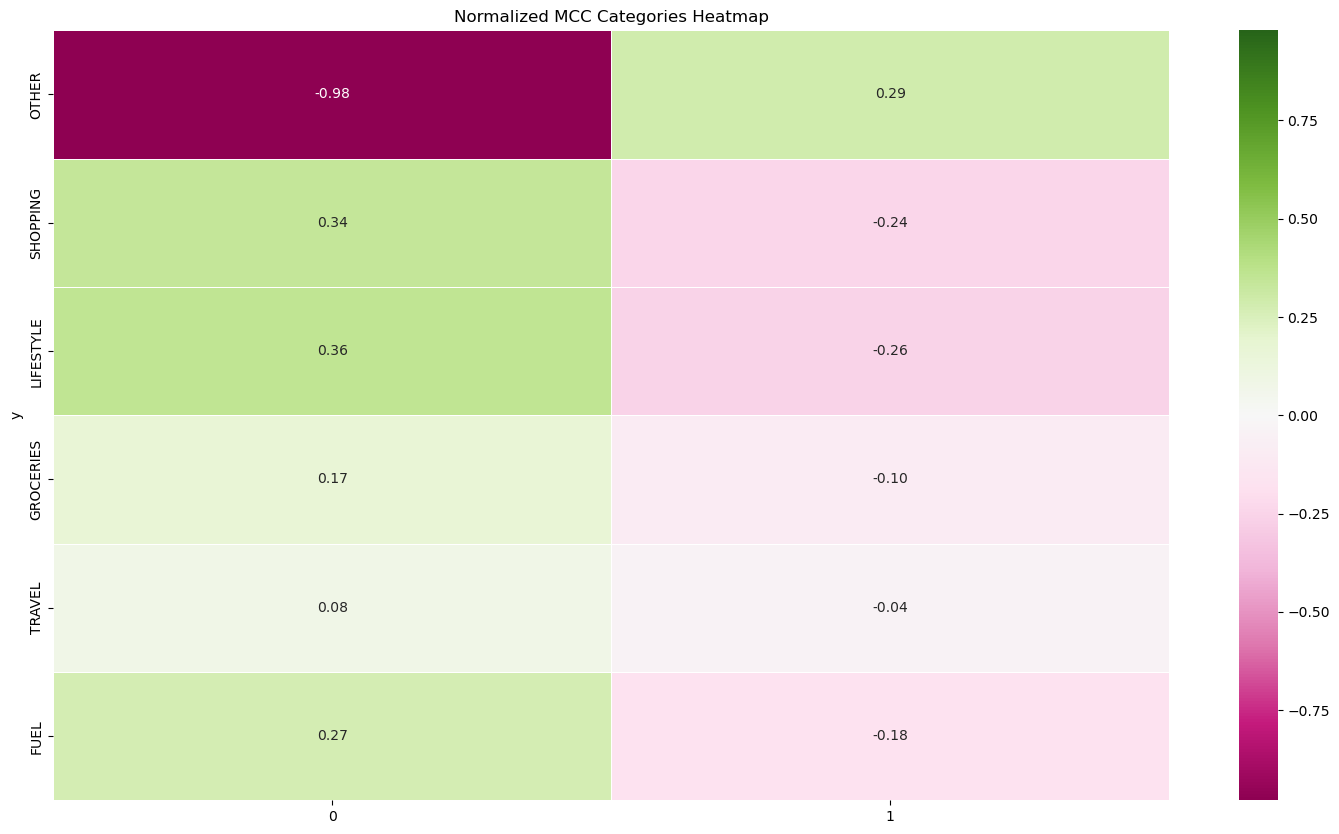

In [111]:
heatmaps(df_clusters, filtered_data, yvalues=['externalParty.transactionCategory'], xvalues=['level_0'], topn=20, relative=True, value='amount', level_detail=True)

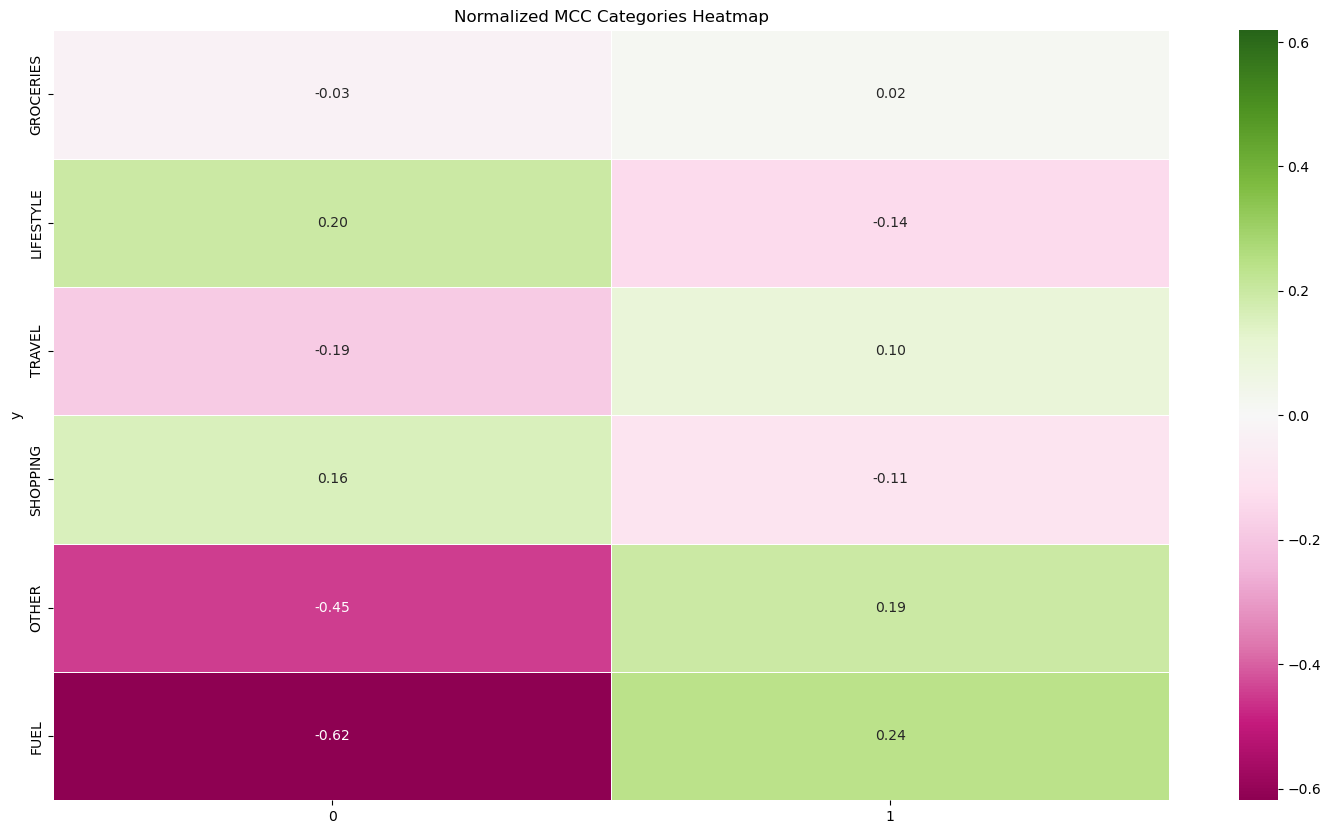

In [62]:
heatmaps(df_clusters, filtered_data, yvalues=['externalParty.transactionCategory'], xvalues=['level_0'], topn=20, relative=True, value='frequency', level_detail=True)

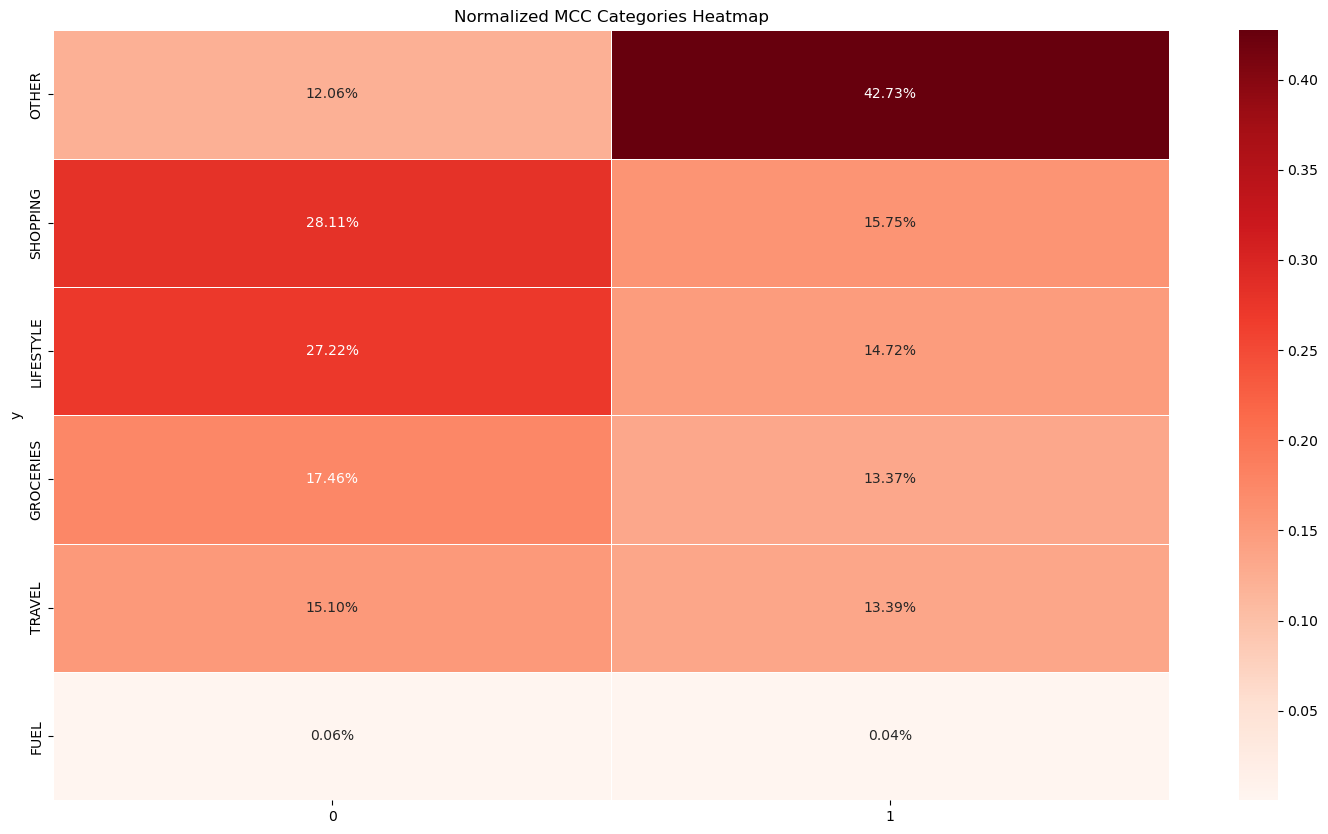

In [112]:
heatmaps(df_clusters, filtered_data, yvalues=['externalParty.transactionCategory'], xvalues=['level_0'], topn=20, relative=False, value='amount', level_detail=True)

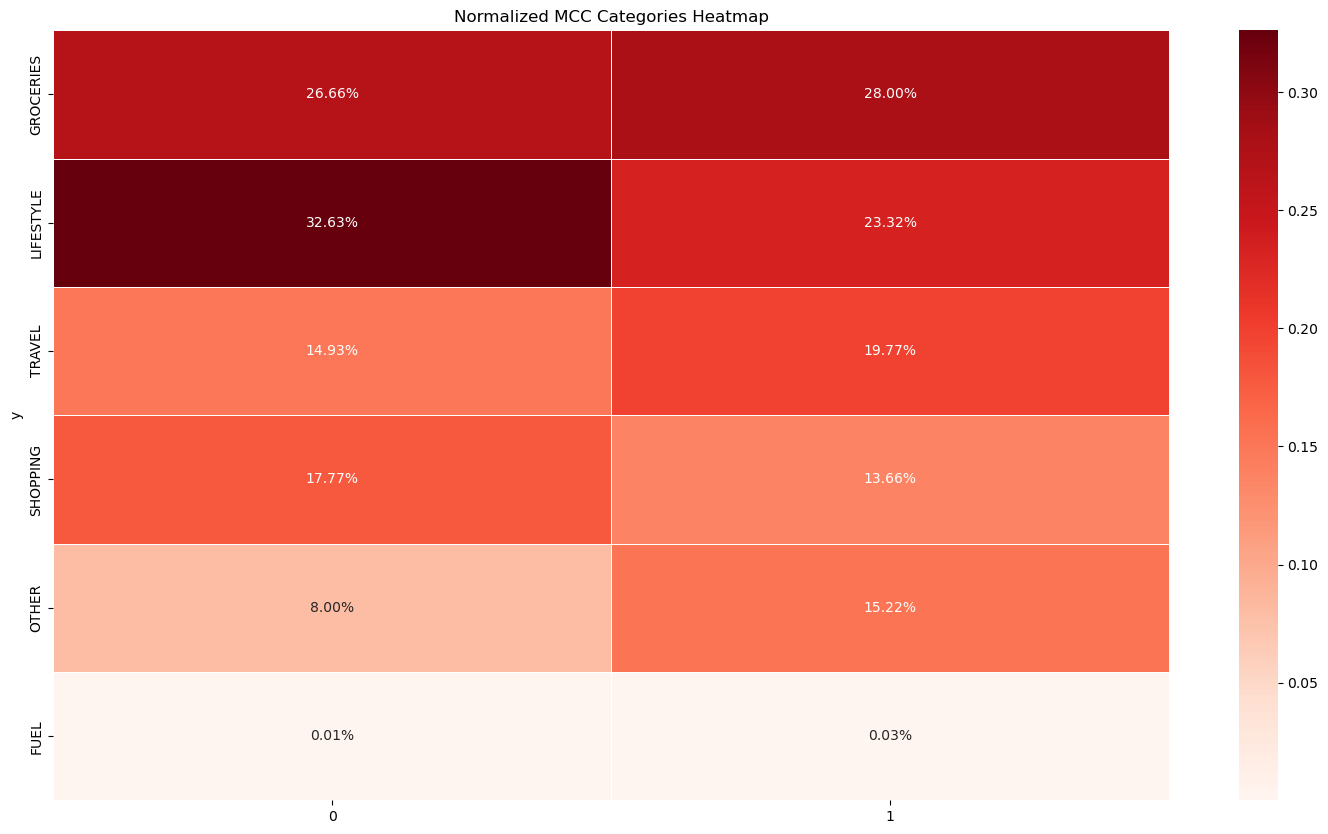

In [68]:
heatmaps(df_clusters, filtered_data, yvalues=['externalParty.transactionCategory'], xvalues=['level_0'], topn=20, relative=False, value='frequency', level_detail=True)

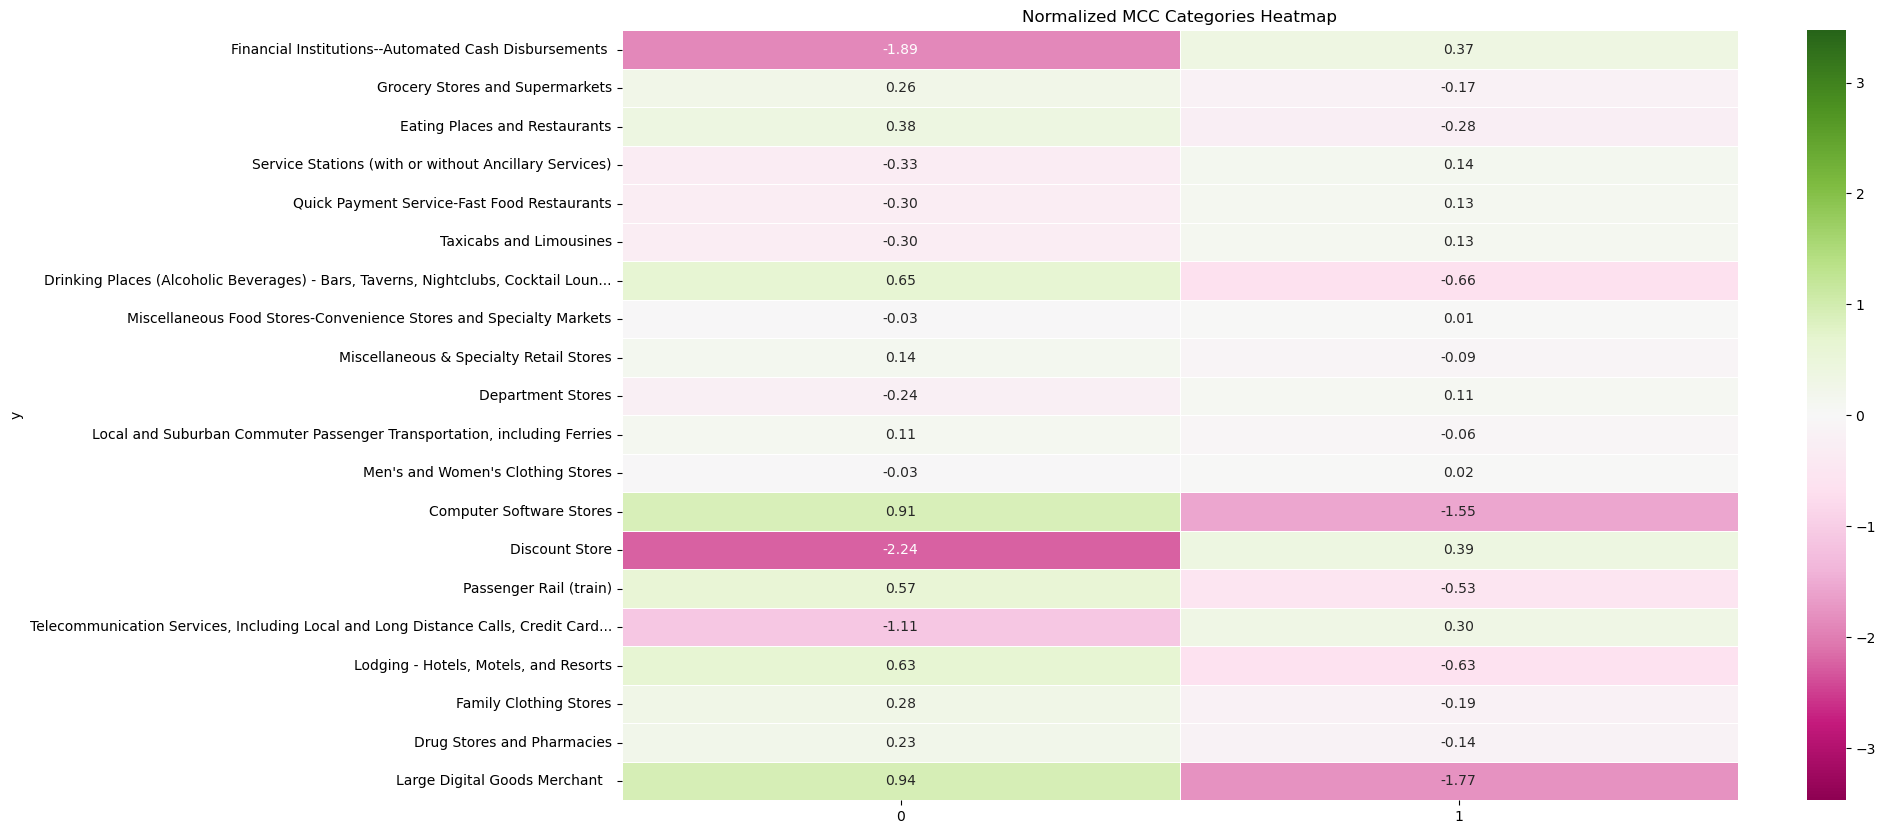

In [113]:
heatmaps(df_clusters, filtered_data, yvalues=['MCC_List'], xvalues=['level_0'], topn=20, relative=True, value='amount', level_detail=True, max_label_len=80)

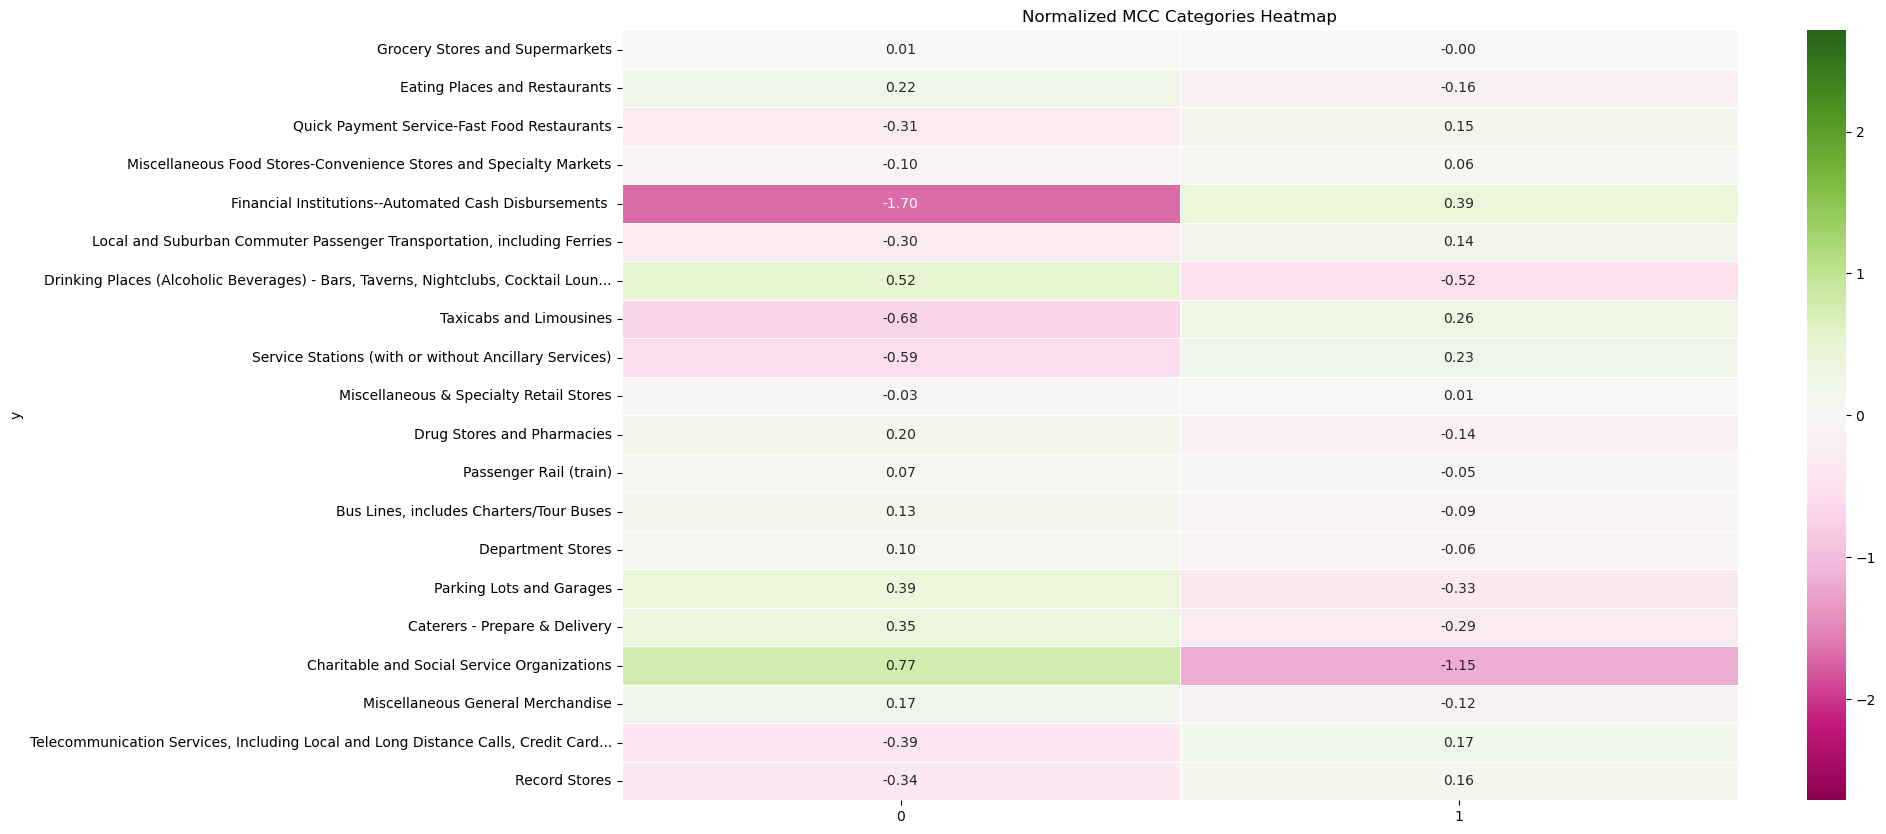

In [70]:
heatmaps(df_clusters, filtered_data, yvalues=['MCC_List'], xvalues=['level_0'], topn=20, relative=True, value='frequency', level_detail=True, max_label_len=80)

In [ ]:
df_imd.columns

Index(['CustomerId', 'Index_of_Multiple_Deprivation_Decile', 'Postcode_Status',
       'LSOA_code', 'LSOA_Name', 'Index_of_Multiple_Deprivation_Rank',
       'Income_Rank', 'Income_Decile', 'Income_Score', 'Employment_Rank',
       'Employment_Decile', 'Employment_Score', 'Education_and_Skills_Rank',
       'Education_and_Skills_Decile', 'Health_and_Disability_Rank',
       'Health_and_Disability_Decile', 'Crime_Rank', 'Crime_Decile',
       'Barriers_to_Housing_and_Services_Rank',
       'Barriers_to_Housing_and_Services_Decile', 'Living_Environment_Rank',
       'Living_Environment_Decile', 'IDACI_Rank', 'IDACI_Decile',
       'IDACI_Score', 'IDAOPI_Rank', 'IDAOPI_Decile', 'IDAOPI_Score', 'age'],
      dtype='object')

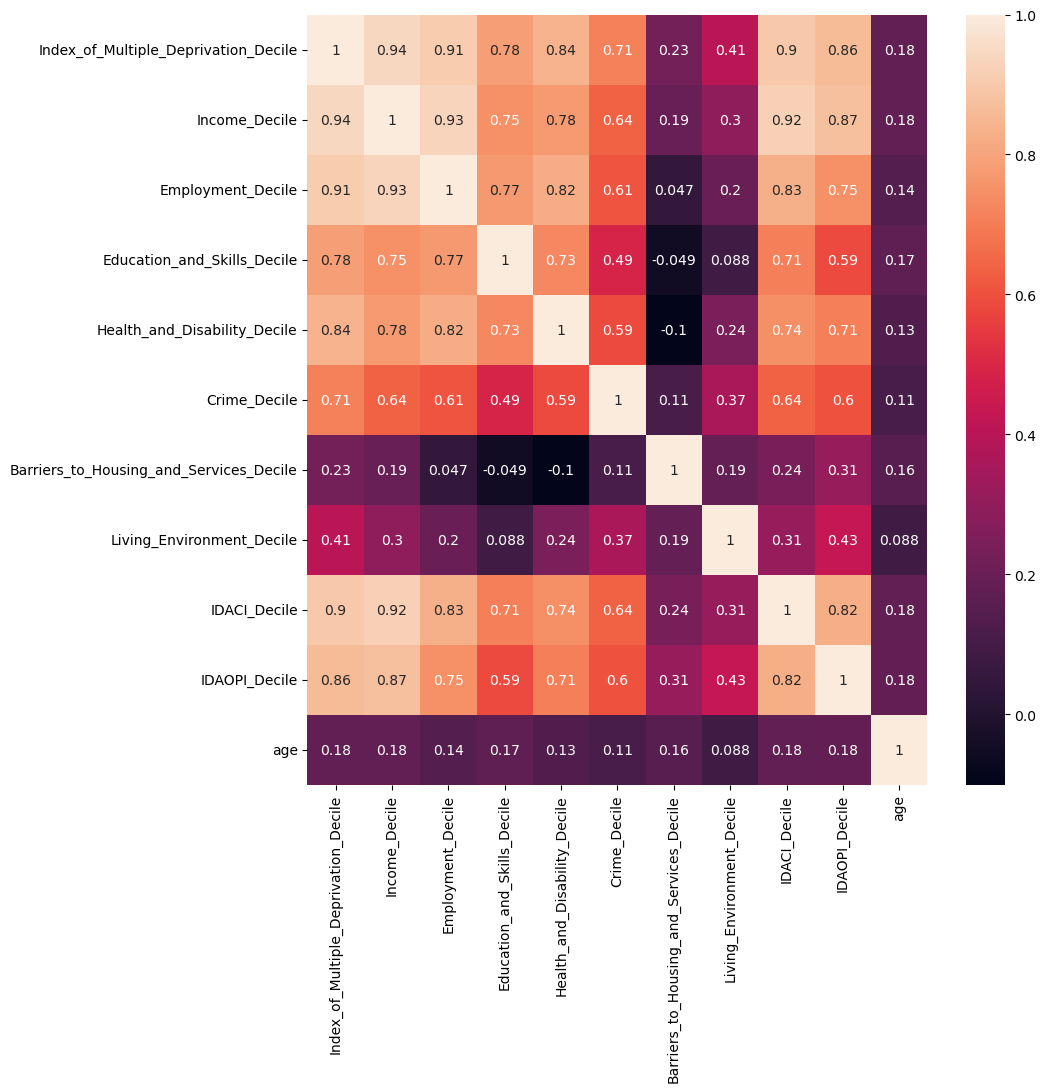

In [117]:
# plot correlation matrix of ['Index_of_Multiple_Deprivation_Decile', 'Income_Decile', 'Employment_Decile', 'Education_Skills_Training_Decile', 'Health_Disability_Decile', 'Crime_Decile', 'Barriers_to_Housing_and_Services_Decile', 'Living_Environment_Decile', 'IDACI_Decile', 'IDAOPI_Decile', 'Age']
plt.figure(figsize=(10,10))
sns.heatmap(df_imd[['Index_of_Multiple_Deprivation_Decile', 'Income_Decile', 'Employment_Decile', 'Education_and_Skills_Decile', 'Health_and_Disability_Decile', 'Crime_Decile', 'Barriers_to_Housing_and_Services_Decile', 'Living_Environment_Decile', 'IDACI_Decile', 'IDAOPI_Decile', 'age']].corr(), annot=True)
# rotate the x-axis labels
# plt.xticks(rotation=45)
plt.show()

In [ ]:
df_clusters['imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Index_of_Multiple_Deprivation_Decile'])
df_clusters['age'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['age'])
# df_clusters['income_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Income_Decile'])
# df_clusters['employ_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Employment_Decile'])
# df_clusters['edu_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Education_and_Skills_Decile'])
# df_clusters['health_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Health_and_Disability_Decile'])
# df_clusters['crime_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Crime_Decile'])
df_clusters['bhs_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Barriers_to_Housing_and_Services_Decile'])
df_clusters['living_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Living_Environment_Decile'])
df_clusters['IDACI_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['IDACI_Decile'])
df_clusters['IDAOPI_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['IDAOPI_Decile'])

IDACI (Income Deprivation Affecting Children Index)

IDAOPI (Income Deprivation Affecting Older People Index)

In [ ]:
df_clusters

node  level_0   imd   age  bhs_imd  \
0    d7742e27-7677-431e-8da4-426e977e958e        0   8.0  23.0      4.0   
1    e1090e22-632f-45e4-a480-b9206b3a573d        0   NaN   NaN      NaN   
2    bae5dffb-f840-4b05-843a-b1a1e50bf98e        0   5.0  32.0      8.0   
3    ba5bf2df-a4ff-44d4-b3c9-1dab98b87580        0  10.0  47.0      3.0   
4    40145ab5-241c-47c5-bb6a-3a05374b28a9        0   4.0   NaN      2.0   
..                                    ...      ...   ...   ...      ...   
364  f601e896-6666-4ff6-a6d0-4748d1412f24        1   4.0  20.0      3.0   
365  f5cb8a1b-f495-4bf5-b261-d3704e2d9324        1   8.0  20.0      5.0   
366  f5bd29b1-42a1-474e-a260-abd9f132c339        1   1.0  25.0      2.0   
367  f582fbee-0081-4b1c-b009-3e45cd4950f6        1   1.0  28.0      1.0   
368  f47e9533-fe63-45ef-a7d8-1c0886dff2d9        1   NaN   NaN      NaN   

     living_imd  IDACI_imd  IDAOPI_imd  
0           3.0        9.0         5.0  
1           NaN        NaN         NaN  
2           3.0        4.0         5.0  
3           8.0        9.0         8.0  
4           5.0        2.0         2.0  
..          ...        ...         ...  
364         6.0        3.0         4.0  
365        10.0        5.0         8.0  
366         1.0        2.0         1.0  
367         4.0        2.0         1.0  
368         NaN        NaN         NaN  

[369 rows x 8 columns]

In [ ]:
df_clusters.isna().sum()

node           0
level_0        0
imd           59
age           71
bhs_imd       59
living_imd    59
IDACI_imd     59
IDAOPI_imd    59
dtype: int64

In [102]:
df_corr = df_clusters.copy()
df_corr.dropna(inplace=True)

In [103]:
df_corr.groupby('level_0')[['imd', 'age', 'bhs_imd', 'living_imd', 'IDACI_imd', 'IDAOPI_imd']].mean()

imd        age   bhs_imd  living_imd  IDACI_imd  IDAOPI_imd
level_0                                                                  
0        6.259259  40.000000  5.518519    4.481481   6.370370    5.481481
1        4.103321  30.158672  4.302583    4.143911   4.077491    3.678967

In [104]:
df_corr.groupby('level_0')['node'].count()

level_0
0     27
1    271
Name: node, dtype: int64

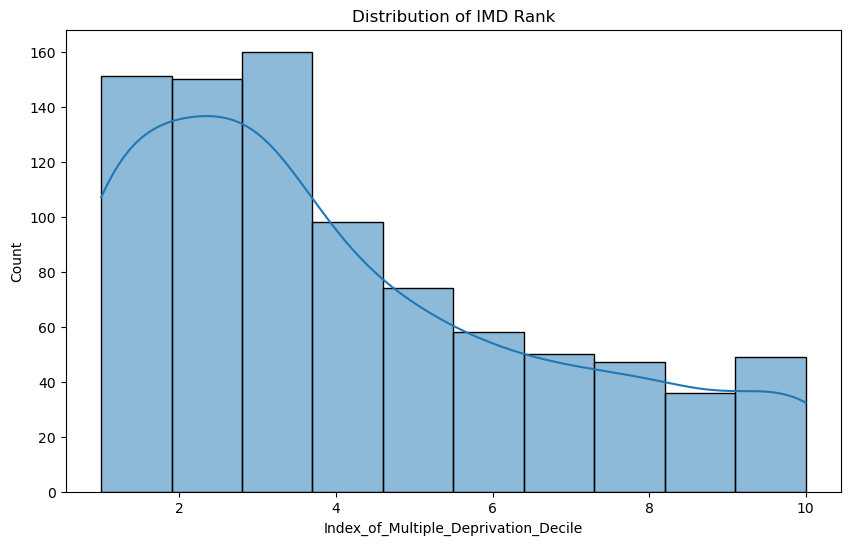

In [110]:
# plot the distribution of imd, age in df_imd
plt.figure(figsize=(10,6))
sns.histplot(df_imd['Index_of_Multiple_Deprivation_Decile'], bins=10, kde=True)
plt.title('Distribution of IMD Rank')
plt.show()

In [108]:
# calculate the chi-square test for each feature to determine the independence of the feature and the cluster(H0: independent, H1: dependent)
from scipy.stats import chi2_contingency
from scipy.stats import chi2

def chi_square_test(df, feature):
    # Create a contingency table
    contingency_table = pd.crosstab(df['level_0'], df[feature])
    # Perform the chi-square test
    stat, p, dof, expected = chi2_contingency(contingency_table)
    # Determine the critical value
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    # Print the results
    print(f'Chi-Square Test for {feature}:')
    print(f'Statistic: {stat:.3f}')
    print(f'p-value: {p:.3f}')
    print(f'Degree of Freedom: {dof}')
    print(f'Critical Value: {critical:.3f}')
    # Determine the significance
    alpha = 1.0 - prob
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    print()

for feature in features:
    chi_square_test(df_corr, feature)

Chi-Square Test for imd:
Statistic: 18.740
p-value: 0.027
Degree of Freedom: 9
Critical Value: 16.919
Dependent (reject H0)

Chi-Square Test for age:
Statistic: 101.061
p-value: 0.000
Degree of Freedom: 38
Critical Value: 53.384
Dependent (reject H0)

Chi-Square Test for bhs_imd:
Statistic: 9.168
p-value: 0.422
Degree of Freedom: 9
Critical Value: 16.919
Independent (fail to reject H0)

Chi-Square Test for living_imd:
Statistic: 8.130
p-value: 0.521
Degree of Freedom: 9
Critical Value: 16.919
Independent (fail to reject H0)

Chi-Square Test for IDACI_imd:
Statistic: 19.235
p-value: 0.023
Degree of Freedom: 9
Critical Value: 16.919
Dependent (reject H0)

Chi-Square Test for IDAOPI_imd:
Statistic: 29.387
p-value: 0.001
Degree of Freedom: 9
Critical Value: 16.919
Dependent (reject H0)



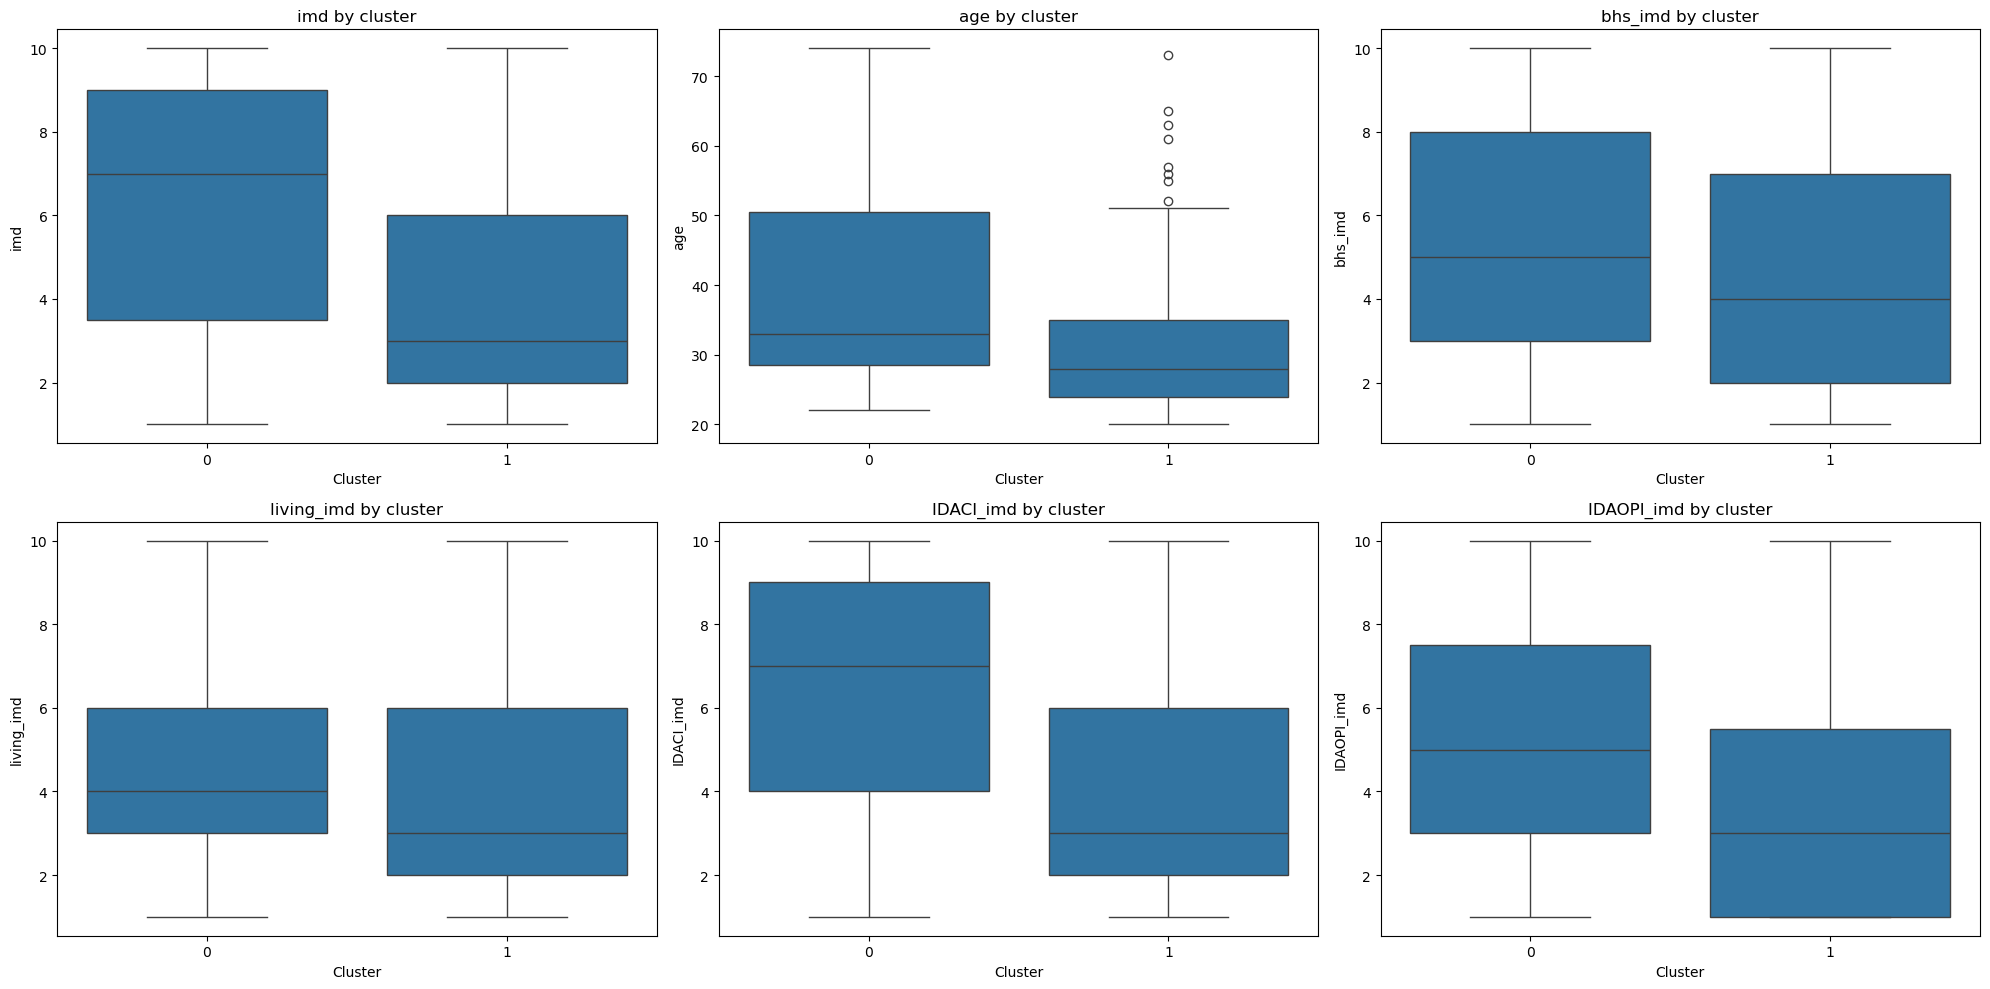

In [106]:
# plot the distribution of each feature for each cluster in a plot of 2x3
features = ['imd', 'age', 'bhs_imd', 'living_imd', 'IDACI_imd', 'IDAOPI_imd']
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, feature in enumerate(features):
    sns.boxplot(x='level_0', y=feature, data=df_corr, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'{feature} by cluster')
    axes[i//3, i%3].set_xlabel('Cluster')
    axes[i//3, i%3].set_ylabel(feature)
plt.tight_layout()
plt.show()

## customers statistics

df_